## Data Ingestion

In [18]:
from google.colab import drive
import pandas as pd


class DataSetLoader:
    """
    A class used to load the dataset from github repository
    """

    def __init__(self, file_path):
        """
        Initialize the DataSetLoader with the path to the dataset file.

        Parameters:
        file_path (str): The path to the dataset CSV file in Google Drive.
        """
        self.file_path = file_path
        self.df = None

    def load_data(self):
        """
        Load the dataset from the specified file path into a pandas DataFrame.
        """
        self.df = pd.read_csv(self.file_path)

    def display_head(self, n=5):
        """
        Display the first few rows of the DataFrame.

        Parameters:
        n (int): The number of rows to display. Default is 5.

        Returns:
        pd.DataFrame: The first n rows of the DataFrame.

        Raises:
        ValueError: If the DataFrame is not loaded.
        """
        if self.df is not None:
            return self.df.head(n)
        else:
            raise ValueError("DataFrame is not loaded. Call load_data() first.")


In [19]:
dataset_url = 'https://raw.githubusercontent.com/21062872/fraud-detection-rag/main/data_files/dataset.csv'
data_loader = DataSetLoader(dataset_url)

# Load the data
data_loader.load_data()

# Display the first few rows of the dataframe
data_loader.display_head()


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


## Data Pre-processing

In [20]:
class Preprocessor:
    def __init__(self, dataframe):
        """
        Initialize the Preprocessor with a pandas DataFrame.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame to preprocess.
        """
        self.df = dataframe

    def strip_characters(self, char="'"):
        """
        Remove specified characters from the start and end of each column value.

        Parameters:
        char (str): The character to remove. Default is single quote (').
        """
        if self.df is not None:
            self.df = self.df.applymap(lambda x: x.strip(char) if isinstance(x, str) else x)
        else:
            raise ValueError("DataFrame is not loaded.")

In [17]:
# Create an instance of the Preprocessor class with the DataFrame
preprocessor = Preprocessor(df)
# Strip leading and trailing ' characters
preprocessor.strip_characters()

In [21]:
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


## Exploratory Data Analysis (EDA)

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

class EDA:
    def __init__(self, df):
        self.df = df

    def plot_imbalance(self, target_variable):
        # Count occurrences of each class
        counts = self.df[target_variable].value_counts()

        # Plotting
        plt.figure(figsize=(6, 4))
        counts.plot(kind='bar', color=['blue', 'red'])
        plt.title('Imbalance of {}'.format(target_variable))
        plt.xlabel('{} (1) vs Not {} (0)'.format(target_variable, target_variable))
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.show()

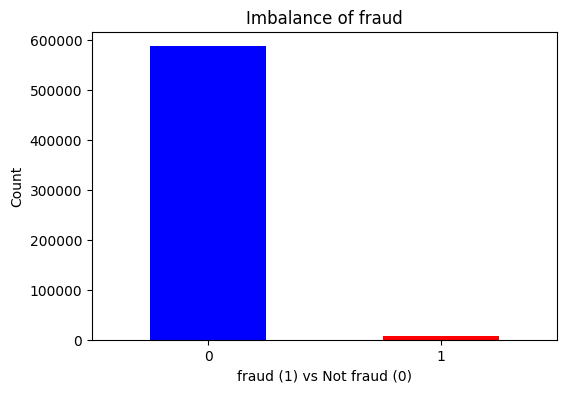

In [24]:
# plot imabalnce of target variable
eda = EDA(df)
eda.plot_imbalance('fraud')